# Detection and Classification of Ultrasonic Vocalizations (USVs) in Rodent Audio Data

In this notebook, we will demonstrate how to **detect** and **classify** ultrasonic vocalizations (USVs) in rodent audio recordings using spectrogram analysis, Geodesic Active Contours (GAC) for segmentation, and a Convolutional Neural Network (CNN) for classification.

## Overview

- **Load Audio Data**: Start by loading an audio file containing rodent vocalizations.
- **Generate Spectrogram**: Create a spectrogram of a selected segment of the audio data to visualize the frequency content over time.
- **Detect USVs**: Use Geodesic Active Contours (GAC) to detect potential USVs in the spectrogram.
- **Classify USVs**: Classify the detected USVs using a pre-trained CNN model to distinguish between different types of vocalizations.

## Importing Libraries

We begin by importing the necessary libraries:

- **torchaudio**: For loading and processing audio data.
- **matplotlib.pyplot**: For plotting and visualizing data.
- **mouse.utils**, **mouse.segmentation**, **mouse.classifier**: Custom modules for sound utilities, segmentation, and classification specific to mouse USVs.
- **pathlib**, **os**: For handling file paths and operating system interactions.
- **typing**, **functools**, **copy**, **tqdm**: For type annotations, function tools, copying objects, and progress bars.


In [42]:
import torchaudio
import matplotlib.pyplot as plt
from matplotlib import colorbar
from matplotlib import rcParams
from mouse.utils import sound_util, data_util
from mouse.segmentation import segmentation, GAC
from mouse.classifier import cnn_classifier
import pathlib
from tqdm import tqdm
import os

## Loading the Audio File
We will load the audio file containing the rodent vocalizations.

## Note
Please ensure that the audio file is present in your working directory. We will also create a `SignalData` object from the audio file.

In [43]:
file_path = "long-example-rodent.wav"
waveform, sample_rate = torchaudio.load(file_path)
signal_data = sound_util.SignalData(pathlib.Path(file_path))

## Generating the Spectrogram

Next, we will generate a spectrogram of the audio data to visualize its frequency content over time.

### Parameters

**Parameters:**

- `signal_data` (*sound_util.SignalData*): The signal data containing the waveform and sample rate.
- `n_fft` (*int*, optional): The size of FFT, creates `n_fft // 2 + 1` bins. Default is `400`.
- `win_length` (*int*, optional): Window size. Default is `n_fft`.
- `hop_length` (*int*, optional): Length of hop between STFT windows. Default is `win_length // 2`.
- `power` (*float*, optional): Exponent for the magnitude spectrogram. Default is `2.0`.
- `center` (*bool*, optional): Whether to pad the input on both sides so that the `t`-th frame is centered at time `t * hop_length`. Default is `True`.
- `pad_mode` (*str*, optional): Controls the padding method used when `center` is `True`. Default is `'reflect'`.
- `vmax` (*float*, optional): The maximum value for the color scale in the spectrogram plot. Default is `5`.
- `t_start` (*float*, optional): The start time (in seconds) for the spectrogram. Default is `None` (start from the beginning).
- `t_end` (*float*, optional): The end time (in seconds) for the spectrogram. Default is `None` (go until the end).

In [44]:
# Generate the spectrogram for a specific time window

# Parameters for spectrogram
n_fft = 400
win_length = None
hop_length = None
power = 2.0
center = True
pad_mode = 'reflect'
vmax = 5
t_start = 6.4  # Start time in seconds
t_end = 7    # End time in seconds

# Set default window length and hop length if not provided
win_length = n_fft if win_length is None else win_length
hop_length = win_length // 2 if hop_length is None else hop_length

# Create a spectrogram transform
spectrogram_transform = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=center,
    pad_mode=pad_mode,
    power=power
)

# Compute the spectrogram for the whole signal
spec_data = sound_util.spectrogram(
    signal_data.signal,
    sample_rate=signal_data.sample_rate,
    spec_calculator=spectrogram_transform,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=power
)

# Clip the spectrogram to the selected time window, if specified
spec_data = sound_util.clip_spectrogram(
    spec_data,
    t_start=t_start,
    t_end=t_end
)


### Visualizing the Spectrogram

We will generate the spectrogram for a specific time window.


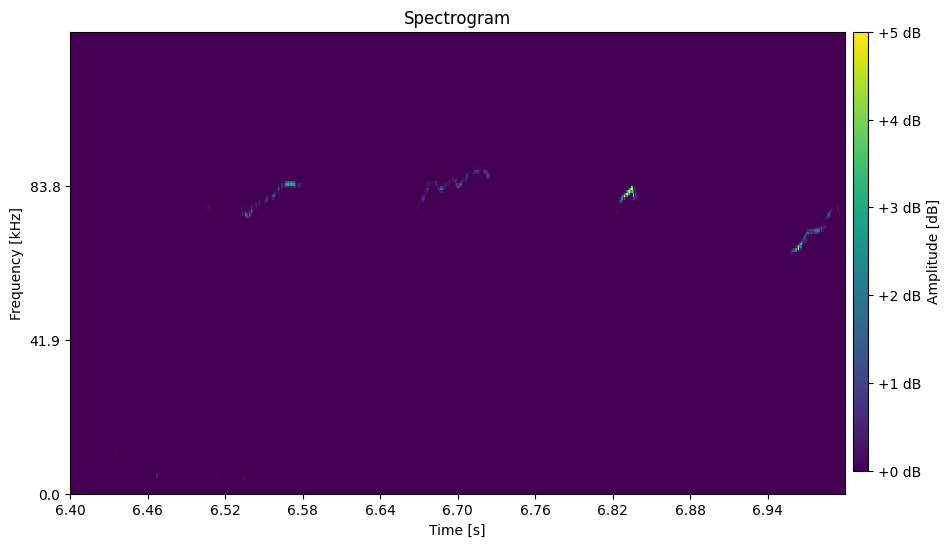

In [45]:
# Plot the spectrogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#2e004f')
cmap = rcParams["image.cmap"]
time_format: str = "{:.2f}"
freq_format: str = "{:.1f}"
xticks_limit: int = 10
yticks_limit: int = 3

spec = sound_util.SpectrogramData

colormesh = ax.pcolormesh(spec_data.spec, cmap=cmap, vmax=vmax)
ax_colorbar = ax.inset_axes([1.01, 0.05, 0.02, 0.95])
cb = colorbar.Colorbar(ax=ax_colorbar, mappable=colormesh, orientation="vertical", format='%+2.0f dB')

# Format labels for x-axis
x_labels = [time_format.format(t) if 0 <= idx < len(spec_data.times) else "" 
            for idx, t in enumerate(spec_data.times)]
ax.set_xticks(range(0, len(spec_data.times), max(1, len(spec_data.times) // xticks_limit)))
ax.set_xticklabels([x_labels[i] for i in ax.get_xticks()])
ax.set_xlabel("Time [s]")

# Format labels for y-axis
y_labels = [freq_format.format(f / 1000) if 0 <= idx < len(spec_data.freqs) else "" 
            for idx, f in enumerate(spec_data.freqs)]
ax.set_yticks(range(0, len(spec_data.freqs), max(1, len(spec_data.freqs) // yticks_limit)))
ax.set_yticklabels([y_labels[i] for i in ax.get_yticks()])
ax.set_ylabel("Frequency [kHz]")

cb.set_label('Amplitude [dB]')
ax.set_title('Spectrogram', color='black')
ax.set_xlabel('Time [s]', color='black')
ax.set_ylabel('Frequency [kHz]', color='black')
ax.tick_params(colors='black')

fig.patch.set_facecolor('white')

## Detecting USVs Using Geodesic Active Contours (GAC)

We will use the Geodesic Active Contour (GAC) method to detect USVs in the spectrogram. This method allows us to segment the spectrogram and find regions that correspond to USVs.

### Parameters

**Parameters:**

- `spec` (*sound_util.SpectrogramData*): The spectrogram data to search for USVs.
- `min_side_length` (*int*): Minimum side length for bounding boxes.
- `level_set`: Used for generating the initial level set based on preprocessed `spec`.
- `tqdm_kwargs`: Keyword arguments for the `tqdm` progress bar.
- `gac_parameters`: Additional arguments passed to `morphological_geodesic_active_contour` from `skimage.segmentation`.


In [46]:
# Detect USVs using GAC
spec = spec_data
min_side_length = 1
level_set = GAC.ones_level_set
tqdm_kwargs = {"desc": "Detecting USVs with GAC"}
gac_parameters = {
    "num_iter": 230,
    "smoothing": 0,
    "threshold": 0.9,
    "balloon": -1
}  # Additional arguments for GAC

# Preprocess the spectrogram
_spec = segmentation.inverse_gaussian_gradient(spec.spec.numpy(), sigma=5, alpha=100)

# Initialize the level set
level_set_init = level_set(_spec)

# Run the GAC algorithm with a progress bar
with tqdm(total=gac_parameters.get("num_iter", 100)) as pbar:
    gac_parameters['iter_callback'] = lambda _: pbar.update(1)
    gac_parameters.pop('iterations', None)  

    # Execute the GAC algorithm
    level_set_result = segmentation.morphological_geodesic_active_contour(
        _spec, init_level_set=level_set_init, **gac_parameters
    )


# Find bounding boxes for the detected regions
boxes = data_util.find_bounding_boxes(level_set_result,
                                      min_side_length=min_side_length)

# Filter the bounding boxes if required
detected_squeaks = data_util.filter_boxes(spec, boxes)


231it [00:00, 484.13it/s]                         


### Visualizing the Detected USVs

We will now visualize the detected USVs by plotting bounding boxes over the spectrogram.

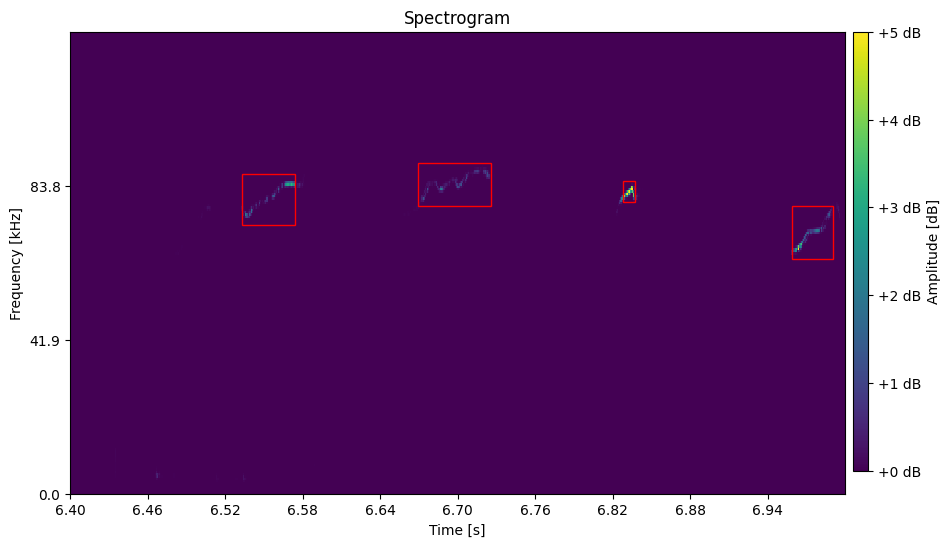

In [47]:
# Plot the spectrogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#2e004f')
cmap = rcParams["image.cmap"]
time_format: str = "{:.2f}"
freq_format: str = "{:.1f}"
xticks_limit: int = 10
yticks_limit: int = 3

spec = sound_util.SpectrogramData

colormesh = ax.pcolormesh(spec_data.spec, cmap=cmap, vmax=vmax)
ax_colorbar = ax.inset_axes([1.01, 0.05, 0.02, 0.95])
cb = colorbar.Colorbar(ax=ax_colorbar, mappable=colormesh, orientation="vertical", format='%+2.0f dB')

# Format labels for x-axis
x_labels = [time_format.format(t) if 0 <= idx < len(spec_data.times) else "" 
            for idx, t in enumerate(spec_data.times)]
ax.set_xticks(range(0, len(spec_data.times), max(1, len(spec_data.times) // xticks_limit)))
ax.set_xticklabels([x_labels[i] for i in ax.get_xticks()])
ax.set_xlabel("Time [s]")

# Format labels for y-axis
y_labels = [freq_format.format(f / 1000) if 0 <= idx < len(spec_data.freqs) else "" 
            for idx, f in enumerate(spec_data.freqs)]
ax.set_yticks(range(0, len(spec_data.freqs), max(1, len(spec_data.freqs) // yticks_limit)))
ax.set_yticklabels([y_labels[i] for i in ax.get_yticks()])
ax.set_ylabel("Frequency [kHz]")

# Draw bounding boxes around detected USVs
for squeak_box in detected_squeaks:
    rect = plt.Rectangle(
        (squeak_box.t_start, squeak_box.freq_start),
        squeak_box.t_end - squeak_box.t_start,
        squeak_box.freq_end - squeak_box.freq_start,
        linewidth=1,
        edgecolor='r',  # Red color for bounding boxes
        facecolor='none'
    )
    ax.add_patch(rect)

cb.set_label('Amplitude [dB]')
ax.set_title('Spectrogram', color='black')
ax.set_xlabel('Time [s]', color='black')
ax.set_ylabel('Frequency [kHz]', color='black')
ax.tick_params(colors='black')

fig.patch.set_facecolor('white')

## Classifying Detected USVs Using a CNN Model

After detecting the USVs, we will classify them using a pre-trained CNN model to determine the type of vocalizations.

### Loading the Pre-trained CNN Model

We will use a pre-trained CNN model for classification. The model checkpoint will be downloaded if it's not already present in the cache directory.

### Parameters

**Parameters:**

- `spec_data` (*sound_util.SpectrogramData*): The spectrogram data.
- `annotations` (*List[data_util.SqueakBox]*): List of detected USVs' bounding boxes.
- `model_name` (*str*): The name of the pre-trained model to use.
- `cache_dir` (*pathlib.Path*): The directory where the model checkpoint is cached.
- `batch_size` (*int*, optional): The batch size for processing. Default is `4`.
- `confidence_threshold` (*float*, optional): The confidence threshold for predictions. Default is `-1` (no threshold).
- `silent` (*bool*, optional): If `True`, suppresses output. Default is `False`.

In [48]:
# Define the pre-trained models and their checkpoints
PRETRAINED_MODELS_CHECKPOINTS = {
    "cnn-binary-v1-custom": {
        "url": "https://zenodo.org/record/6868406/files/cnn_binary_v1_custom.ckpt",
        "filename": "cnn_binary_v1_custom.ckpt",
    }
}

# Specify the cache directory and model name
cache_dir = pathlib.Path("./model_cache")
model_name = "cnn-binary-v1-custom"

# Get the model checkpoint path
model_path = cache_dir.joinpath(PRETRAINED_MODELS_CHECKPOINTS[model_name]["filename"])

# Download the model if not present
if not model_path.exists():
    os.makedirs(str(cache_dir), exist_ok=True)
    data_util.download_file(PRETRAINED_MODELS_CHECKPOINTS[model_name]["url"], output_path=str(model_path))

# Load the pre-trained model
model = cnn_classifier.USVClassifier.load_from_checkpoint(str(model_path), inference_only=True)

# Classify the annotations using the model
classified_squeaks = model.predict_for_annotations(
    spec_data,
    annotations=detected_squeaks,
    batch_size=4,
    confidence_threshold=-1,
    silent=False,
    callback=None,
)


Lightning automatically upgraded your loaded checkpoint from v1.6.3 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint model_cache/cnn_binary_v1_custom.ckpt`
/Users/ksawery.ostrowski/Library/Caches/pypoetry/virtualenvs/mouse-gui-jR5cZok3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ksawery.ostrowski/Library/Caches/pypoetry/virtualenvs/mouse-gui-jR5cZok3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 4/4 [00:00<00:00, 238.62it/s]


### Visualizing the Classified USVs

We will visualize the classified USVs by plotting bounding boxes with different colors based on their classification. Remember that you may choose different  labels for the classification.

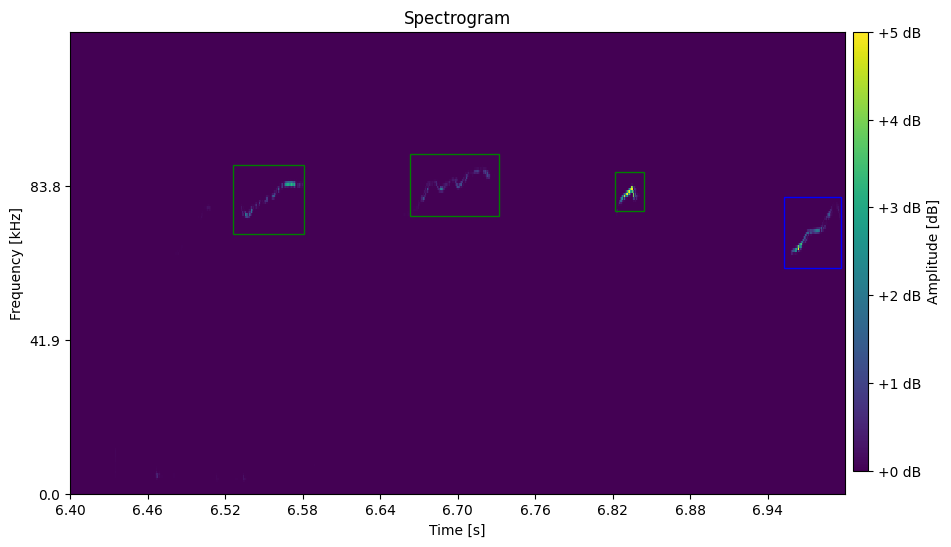

In [49]:
# Plot the spectrogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#2e004f')
cmap = rcParams["image.cmap"]
time_format: str = "{:.2f}"
freq_format: str = "{:.1f}"
xticks_limit: int = 10
yticks_limit: int = 3

spec = sound_util.SpectrogramData

colormesh = ax.pcolormesh(spec_data.spec, cmap=cmap, vmax=vmax)
ax_colorbar = ax.inset_axes([1.01, 0.05, 0.02, 0.95])
cb = colorbar.Colorbar(ax=ax_colorbar, mappable=colormesh, orientation="vertical", format='%+2.0f dB')

# Format labels for x-axis
x_labels = [time_format.format(t) if 0 <= idx < len(spec_data.times) else "" 
            for idx, t in enumerate(spec_data.times)]
ax.set_xticks(range(0, len(spec_data.times), max(1, len(spec_data.times) // xticks_limit)))
ax.set_xticklabels([x_labels[i] for i in ax.get_xticks()])
ax.set_xlabel("Time [s]")

# Format labels for y-axis
y_labels = [freq_format.format(f / 1000) if 0 <= idx < len(spec_data.freqs) else "" 
            for idx, f in enumerate(spec_data.freqs)]
ax.set_yticks(range(0, len(spec_data.freqs), max(1, len(spec_data.freqs) // yticks_limit)))
ax.set_yticklabels([y_labels[i] for i in ax.get_yticks()])
ax.set_ylabel("Frequency [kHz]")

# Draw bounding boxes around classified USVs with different colors
for squeak_box in classified_squeaks:
    color = 'b' if squeak_box.label == "call" else 'g'  # Blue for 'call', green otherwise
    rect = plt.Rectangle(
        (squeak_box.t_start, squeak_box.freq_start),
        squeak_box.t_end - squeak_box.t_start,
        squeak_box.freq_end - squeak_box.freq_start,
        linewidth=1,
        edgecolor=color,
        facecolor='none'
    )
    ax.add_patch(rect)

cb.set_label('Amplitude [dB]')
ax.set_title('Spectrogram', color='black')
ax.set_xlabel('Time [s]', color='black')
ax.set_ylabel('Frequency [kHz]', color='black')
ax.tick_params(colors='black')

fig.patch.set_facecolor('white')

## Conclusion

In this notebook, we demonstrated how to detect and classify ultrasonic vocalizations (USVs) in rodent audio recordings. We:

- Loaded and visualized the audio data using spectrograms.
- Detected USVs using Geodesic Active Contours (GAC).
- Classified the detected USVs using a pre-trained CNN model.
- Visualized the results by plotting bounding boxes over the spectrogram.

This process can be used to analyze rodent vocalizations in research and study their behavior.